In [46]:
suppressPackageStartupMessages({
  library(dplyr)
  library(dataorganizer)
  library(reshape2)
  library(devtools)
  library(cellAdmix)
  library(ggplot2)
  library(ggrepel)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks


In [2]:
# load the precomputed marker genes
markers <- DatasetPath('nsclc_rna', 'nsclc_markers_list_full.tsv') %>%
  read.table(sep = '\t',header=TRUE)
tumor.marker.genes <- markers$Gene[markers$cluster=='malignant']
macro.marker.genes <- markers$Gene[markers$cluster=='macrophage']
fibroblast.marker.genes <- markers$Gene[markers$cluster=='fibroblast']

In [27]:
# load precomputed LR results from NSCLC_run_lR.R
spatial_all_scores_orig <- CachePath('nsclc_scaled_dat11/LR_scores_full_orig.rds') %>% readRDS()
spatial_all_scores_cln <- CachePath('nsclc_scaled_dat11/LR_scores_full_cln.rds') %>% readRDS()

In [ ]:
sc_obj <- load_scrnaseq_matrix_nsclc()

scale_factor <- colSums(sc_obj[['RNA']]$counts)[1]
sc_obj[['RNA']]$data <- log1p(sc_obj[['RNA']]$counts * 10000 / scale_factor) # to use same scale factor as seurat default

In [9]:
### creating a version of the fractional counts with z-transform across cell types
frac_counts <- sc_obj[['RNA']]$counts / scale_factor
all_ct <- as.character(unique(sc_obj$cell_type))
av_frac_counts <- lapply(all_ct, \(ct){
  cells_keep <- colnames(sc_obj)[as.character(sc_obj$cell_type)==ct]
  frac_counts_sub <- frac_counts[,cells_keep]
  av_frac_ct <- rowMeans(frac_counts_sub)
  return(av_frac_ct)
})
av_frac_counts_all_ct <- do.call(cbind,av_frac_counts)
av_frac_counts_scaled <- t(scale(t(av_frac_counts_all_ct)))
colnames(av_frac_counts_scaled) <- all_ct

# needs columns of 'gene', 'celltype', 'z'
g <- rep(rownames(av_frac_counts_scaled),ncol(av_frac_counts_scaled))
ct <- sapply(colnames(av_frac_counts_scaled),function(ct){
  return(rep(ct,nrow(av_frac_counts_scaled)))
})
ct <- c(ct)
z <- c(av_frac_counts_scaled)
ct_exp <- cbind.data.frame(g,ct,z)
colnames(ct_exp) <- c('gene','celltype','z')
ct_exp$celltype <- factor(ct_exp$celltype,levels=levels(sc_obj@meta.data$cell_type))
head(ct_exp)

,gene,celltype,z
,<chr>,<fct>,<dbl>
1,5S-rRNA,CD4+ T cells,-0.23194827
2,5-8S-rRNA,CD4+ T cells,-0.04040829
3,7SK,CD4+ T cells,-0.41558549
4,A1BG,CD4+ T cells,-0.39901089
5,A1BG-AS1,CD4+ T cells,-0.39967922
6,A1CF,CD4+ T cells,-0.34069447


In [38]:
orig_lr <- plot_lr_results(spatial_all_scores_orig,p_thresh=.05,fc_thresh=.25)
orig_plt <- orig_lr[[1]]
orig_pval <- orig_lr[[2]]

cln_lr <- plot_lr_results(spatial_all_scores_cln,p_thresh=.05,fc_thresh=.25)
cln_plt <- cln_lr[[1]]
cln_pval <- cln_lr[[2]]

print(orig_pval)
print(cln_pval)

[1] 0.0007969172
[1] 0.5084045


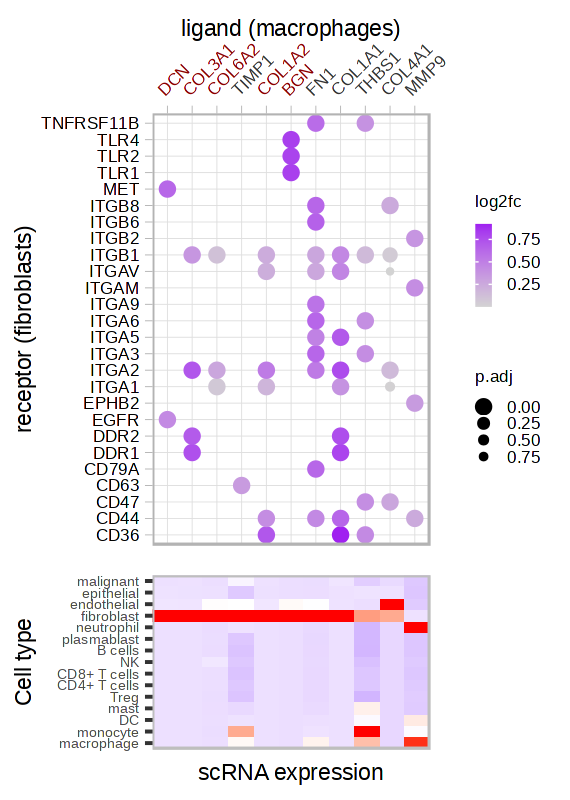

In [39]:
options(repr.plot.width = 2.85, repr.plot.height = 4, repr.plot.res = 200)
orig_plt

In [40]:
pdf(OutputPath("nsclc_macrophage_fib_orig.pdf"), useDingbats=FALSE, width=2.85, height=4)
orig_plt
dev.off()

png 
  2

In [41]:
cln_plt <- plot_lr_results(spatial_all_scores_cln,p_thresh=.05,fc_thresh=.25)

[[1]]

[[2]]
[1] 0.5084045


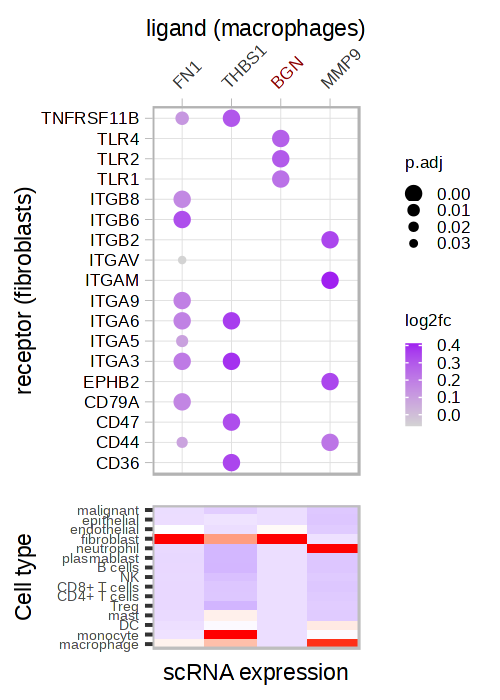

In [42]:
options(repr.plot.width = 2.5, repr.plot.height = 3.5, repr.plot.res = 200)

cln_plt

In [43]:
pdf(OutputPath("nsclc_macrophage_fib_cln.pdf"), useDingbats = FALSE, width = 2.5, height = 4)
cln_plt
dev.off()

[[1]]

[[2]]
[1] 0.5084045


png 
  2

Warning message:
“Removed 587 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


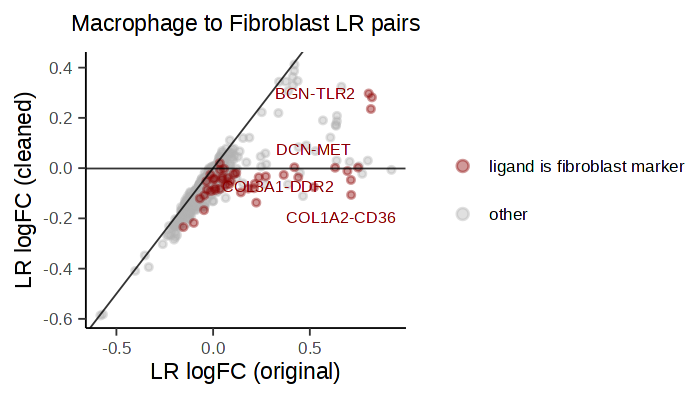

In [47]:
options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 200)

##### plotting clean vs orig LR fold changes
r_keep <- which(spatial_all_scores_orig$LR_cell_comb=='macrophage--fibroblast')
icg1 <- spatial_all_scores_orig[r_keep,]
icg1 <- as.data.frame(icg1)

r_keep <- which(spatial_all_scores_cln$LR_cell_comb=='macrophage--fibroblast')
icg2 <- spatial_all_scores_cln[r_keep,]
icg2 <- as.data.frame(icg2)

rownames(icg1) <- paste0(icg1$LR_comb,':',icg1$LR_cell_comb)
rownames(icg2) <- paste0(icg2$LR_comb,':',icg2$LR_cell_comb)
icg <- cbind.data.frame(icg1[,'log2fc'],icg2[rownames(icg1),'log2fc']) ### need to index one of them so that rows match up
colnames(icg) <- c('orig','cln')
icg$LR_comb <- icg1$LR_comb
icg$ligand <- icg1$ligand

icg$markers <- sapply(icg$ligand,function(x){
  if (x %in% fibroblast.marker.genes) {
    return('ligand is fibroblast marker')
  } else {
    return('other')
  }
})

icg$markers <- factor(icg$markers,levels=c('ligand is fibroblast marker','other'))
myColors <- c('red4','grey70')

icg$plab <- NA
mylabs <- c('COL1A2-CD36','COL3A1-DDR2','BGN-TLR2','DCN-MET')
ndx_lab <- match(mylabs,icg$LR_comb)
icg$plab[ndx_lab] <-  mylabs
p <- ggplot(icg,aes(x=orig,y=cln,label=plab,color=markers)) +
  geom_point(data=icg[icg$markers=='other',],alpha=gg_point_alpha/2,size=gg_point_size) +
  geom_point(data=icg[icg$markers=='ligand is fibroblast marker',],alpha=gg_point_alpha/2,size=gg_point_size) +
  geom_text_repel(size=geom_text_size, family=font_choice, show.legend = FALSE) +
  geom_hline(yintercept = 0,alpha=gg_line_alpha,linewidth=gg_line_thickness) +
  geom_abline(slope=1,intercept=0,alpha=gg_line_alpha,linewidth=gg_line_thickness) +
  xlab("LR logFC (original)") +
  ylab("LR logFC (cleaned)") +
  scale_colour_manual(breaks = c('ligand is fibroblast marker','other'), values = myColors) +
  ggtitle('Macrophage to Fibroblast LR pairs') +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod


p


In [48]:
pdf(OutputPath("nsclc_macrophage_LR_pre_post.pdf"), useDingbats = FALSE, width = 3.5, height = 2)
p
dev.off()

Warning message:
“Removed 587 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


png 
  2